In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler
from scipy.stats import t
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import minimize

In [430]:
user = pd.read_csv("USER.txt", delimiter="\t")
user['date'] = pd.to_datetime(user['date'], format='%Y%m') + pd.offsets.MonthBegin(0)
data = user[['Cusip', 'date', 'EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF', 'PM71', 'ret', 'CRET']]
data = data.groupby('Cusip').apply(lambda x: x.sort_values('date').drop_duplicates()).reset_index(drop=True)
data['ret1'] = data.groupby('Cusip')['ret'].shift(-1)
data['CRET1'] = data.groupby('Cusip')['CRET'].shift(-1)
data = data.dropna().reset_index(drop=True)
data = data[(data['date'] >= '1995-1-01') & (data['date'] < '2021-1-1')]
startDate = data['date'].min()
endDate = data['date'].max()

# Getting Coefficients with WLRR

In [3]:
def weight(data, X, y):
    model = sm.OLS(data[y], sm.add_constant(data[X])).fit()
    # save the residuals and standard errors to a new dataframe
    CRWT = pd.DataFrame({'residual': model.resid, 'stder': np.sqrt(model.scale)})
    # calculate weights
    CRWT['WT'] = (1 - (abs(CRWT['residual'] / CRWT['stder']) / 4.685) ** 2) ** 2
    CRWT = CRWT.loc[(CRWT['WT'].notnull()) & (abs(CRWT['residual'] / CRWT['stder']) < 4.685)]
    ################## STEP2: calculate weighted variables ##################
    Wdata = pd.DataFrame()
    for i in range(len(X)):
        Wdata['W'+ X[i]] = CRWT['WT'] * data[X[i]]
    Wdata['WTR'] = CRWT['WT'] * data[y]
    ################## STEP3: Normalize data ##################
    var_names = list(Wdata.columns)
    scaler = StandardScaler()
    scaler.fit(Wdata[var_names])
    CWdata = Wdata.copy()
    CWdata[var_names] = scaler.transform(Wdata[var_names])
    return CWdata, Wdata, var_names
def regression(CWdata, Wdata, var_names):
    ################## STEP4: Compute variance matrix ##################
    X = CWdata[var_names[:-1]].values
    Y = CWdata[var_names[-1]].values
    P = X.shape[1]
    N = X.shape[0]
    DF = N-1
    CORR = np.dot(X.T, X) / DF
    # print(CORR)
    # -- eigen decomposition => A=LATENT ROOTS, V=LATENT VECTORS
    A, V = np.linalg.eig(CORR)
    # print(A)
    # print(V)
    Z = np.dot(X, V)
    PC = np.dot(np.linalg.inv(np.dot(Z.T, Z)), np.dot(Z.T, Y))
    # print(PC)
    id = np.ones(P)
    j = np.arange(0, P)
    # j = np.arange(1, P+1)
    # print(id)
    # print(j)
    # -- revise matrix A, id=0 if A < 0.3, dim = sum(id==1), 
    for i in range(P):
        if A[i] <= 0.3:
            A[i] = 0
            id[i] = 0
    # print(A)
    # print(id)
    dim = int(np.sum(id)) 
    indx = np.zeros(dim)
    # print(dim)
    # print(indx)
    k = 0
    for i in range(P):
        if id[i] == 1:
            indx[k] = j[i]
            k += 1
    indx = indx.astype(int)
    # print(indx)
    # Define PC9, V9, IPC9, MSE, ZZ, ZZ9 and STDB9
    PC9 = PC[indx]
    V9 = V[:,indx]
    IPC9 = np.dot(V9, PC9)
    MSE = (np.dot(Y.T, Y) - np.dot(PC.T, np.dot(Z.T, Y))) / (DF - PC9.shape[0])
    ZZ = np.dot(Z.T, Z)
    ZZ9 = ZZ[np.ix_(indx, indx)]
    # print(PC9)
    # print(V9)
    # print(ZZ9)
    STDB9 = np.sqrt(MSE * np.diag(np.dot(np.dot(V9, np.linalg.inv(ZZ9)), V9.T)))
    X1 = Wdata[var_names[:-1]].values
    Y1 = Wdata[var_names[-1]].values
    SUMX = np.sum(X1, axis=0)
    SUMY = np.sum(Y1)
    # calculate the mean of each column
    X_centered = X1 - np.mean(X1, axis=0)
    SSCP = np.dot(X_centered.T, X_centered)
    # # subtract the mean from each data point
    Y_centered = Y1 - np.mean(Y1, axis=0)
    SSY = np.dot(Y_centered.T, Y_centered)
    # print(SSCP)
    # print(SSY)
    STDX = np.sqrt(np.diag(SSCP))
    STDY = np.sqrt(SSY)
    PC9S = STDY * (IPC9.T/ STDX) # PC9S => beta1--beta9
    # print(PC9S)
    STDPC9S = STDY * (STDB9 / STDX) # STDPC9S => std error of beta1--beta9
    TPC9 = PC9S / STDPC9S # TPC9 => t-statistics
    INT = SUMY / N - PC9S @ (SUMX / N) # INT => intercept beta0
    # print(INT)
    X_vars = var_names[:-1]
    # output = pd.DataFrame( np.column_stack((X_vars, PC9S.T, TPC9.T)),columns=['varaible', 'Parameters', 't-statistics'])
    # output['pvalue'] = (1 - t.cdf(abs(output['t-statistics'].values.astype(float)), DF)) * 2
    output = pd.DataFrame(np.column_stack((X_vars, PC9S.T, TPC9.T)),columns=['variable', 'Parameters', 't-statistics'])
    output = output.astype(dtype= {"variable":"str", "Parameters":"float64","t-statistics":"float64"})
    output.loc[ (abs(output['t-statistics']) < 1.645) | (output['Parameters'] <0) , 'Parameters'] = 0
    #output['Parameters'] = scaler.fit_transform(output[['Parameters']])
    nonzero_params = output.loc[output['Parameters'] != 0, 'Parameters']
    output.loc[output['Parameters'] != 0, 'Parameters'] = nonzero_params / nonzero_params.sum()
    return output

def WLRR(data, X, y, startDate, endDate, outlier_window, reg_window):
    month_output = pd.DataFrame(columns=['Date']+ ['W' + i for i in X])
    month_output_t = pd.DataFrame(columns=['Date']+ ['W' + i for i in X])
    i = 0
    while startDate <= endDate:
        weightstartDate = (startDate + relativedelta(months=-outlier_window)).strftime('%Y-%m-%d')
        weightendDate = startDate.strftime('%Y-%m-%d')
        weight_data = data[(data['date'] >= weightstartDate) & (data['date'] <= weightendDate)]
        CWdata, Wdata, var_names = weight(weight_data, X, y)
 
        regstartDate = (startDate + relativedelta(months=-reg_window)).strftime('%Y-%m-%d')
        regendDate = (startDate).strftime('%Y-%m-%d')
        # print(regstartDate)
        # print(regendDate)
        CWdata = CWdata[(data['date'] >= regstartDate) & (data['date'] <= regendDate)]
        Wdata = Wdata[(data['date'] >= regstartDate) & (data['date'] <= regendDate)]
#         print(startDate, len(CWdata))
        if len(CWdata) == 0:
            month_output.loc[i] = [startDate] + list(output.Parameters)
            month_output_t.loc[i] = [startDate] + list(output['t-statistics'])
            startDate += relativedelta(months=+1)
            i += 1
            continue
        output = regression(CWdata, Wdata, var_names)
        month_output.loc[i] = [startDate] + list(output.Parameters)
        month_output_t.loc[i] = [startDate] + list(output['t-statistics'])
        startDate += relativedelta(months=+1)
        i += 1
    return month_output, month_output_t

## REG8

In [4]:
X = ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP']
y = 'ret1'
REG8, REG8_t = WLRR(data, X, y, startDate, endDate, 60, 1)
REG8_result = REG8.groupby(REG8.index // 12).mean()
REG8_result['date'] = REG8.Date[::12].reset_index(drop = True)
print(REG8_result.mean())
REG8_result

WEP     0.234097
WBP     0.183279
WCP     0.154362
WSP     0.053240
WREP    0.176523
WRBP    0.057849
WRCP    0.088762
WRSP    0.045477
dtype: float64


,WEP,WBP,WCP,WSP,WREP,WRBP,WRCP,WRSP,date
0,0.270821,0.196641,0.075568,0.000000,0.232271,0.016300,0.041732,0.000000,1995-01-01
1,0.216816,0.315376,0.113232,0.065755,0.151411,0.011457,0.049516,0.076438,1996-01-01
2,0.242467,0.386515,0.145375,0.000000,0.134757,0.047874,0.043011,0.000000,1997-01-01
3,0.243149,0.134281,0.122290,0.000000,0.288233,0.000000,0.161164,0.050884,1998-01-01
4,0.241845,0.242678,0.141595,0.042224,0.159203,0.011826,0.064734,0.095894,1999-01-01
5,0.255212,0.301459,0.189879,0.016479,0.085228,0.043913,0.040976,0.066855,2000-01-01
6,0.241182,0.260419,0.201924,0.008096,0.107353,0.069169,0.071907,0.039950,2001-01-01
7,0.294034,0.275284,0.198616,0.012201,0.117821,0.045010,0.026947,0.030087,2002-01-01
8,0.109858,0.353004,0.061068,0.146683,0.154730,0.076098,0.002407,0.096152,2003-01-01
9,0.214345,0.297504,0.199278,0.057361,0.103649,0.035519,0.074345,0.018001,2004-01-01


In [5]:
REG8_result.to_excel("REG8_WLRR.xlsx")
# writer = pd.ExcelWriter('REG8_coef_t.xlsx')
# REG8.to_excel(writer, sheet_name='REG8_coef', index=False)
# REG8_t.to_excel(writer, sheet_name='REG8_t_statistics', index=False)
# writer.save()

## REG9

In [6]:
X = ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF']
y = 'ret1'
CTEF, CTEF_t = WLRR(data, X, y, startDate, endDate, 60, 1)
CTEF_result = CTEF.groupby(CTEF.index // 12).mean()
CTEF_result['date'] = CTEF.Date[::12].reset_index(drop = True)
print(CTEF_result.mean())
CTEF_result

WEP      0.162940
WBP      0.149077
WCP      0.106897
WSP      0.044738
WREP     0.124477
WRBP     0.056525
WRCP     0.063379
WRSP     0.041863
WCTEF    0.250105
dtype: float64


,WEP,WBP,WCP,WSP,WREP,WRBP,WRCP,WRSP,WCTEF,date
0,0.172579,0.155846,0.053074,0.000000,0.137303,0.014927,0.026731,0.000000,0.439541,1995-01-01
1,0.138376,0.209292,0.077179,0.050629,0.094512,0.033471,0.031680,0.060779,0.304082,1996-01-01
2,0.156083,0.296016,0.097241,0.000000,0.083357,0.046296,0.022278,0.000000,0.298728,1997-01-01
3,0.139370,0.106910,0.063836,0.000000,0.161592,0.013560,0.089016,0.033050,0.392666,1998-01-01
4,0.203141,0.231113,0.127579,0.042110,0.127544,0.012002,0.055575,0.094817,0.106119,1999-01-01
5,0.185121,0.239543,0.126714,0.016977,0.059791,0.048661,0.026317,0.066356,0.230521,2000-01-01
6,0.211787,0.234817,0.175658,0.008115,0.101814,0.069120,0.068686,0.039748,0.090255,2001-01-01
7,0.214883,0.223453,0.143408,0.012118,0.086839,0.045265,0.021524,0.029959,0.222551,2002-01-01
8,0.063384,0.281098,0.046154,0.132136,0.089440,0.086086,0.002428,0.101196,0.198078,2003-01-01
9,0.165778,0.250592,0.154336,0.050336,0.078326,0.035022,0.057008,0.016296,0.192305,2004-01-01


In [7]:
CTEF_result.to_excel("REG9_WLRR.xlsx")
# writer = pd.ExcelWriter('REG9_coef_t.xlsx')
# CTEF.to_excel(writer, sheet_name='REG9_coef', index=False)
# CTEF_t.to_excel(writer, sheet_name='REG9_t_statistics', index=False)
# writer.save()

## REG10 

In [8]:
X = ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF', 'PM71']
y = 'ret1'
USER10, USER10_t = WLRR(data, X, y, startDate, endDate, 60, 1)
USER10_result = USER10.groupby(USER10.index // 12).mean()
USER10_result['date'] = USER10.Date[::12].reset_index(drop = True)
print(USER10_result.mean())
USER10_result

WEP      0.125585
WBP      0.135125
WCP      0.082633
WSP      0.035561
WREP     0.102430
WRBP     0.065912
WRCP     0.053872
WRSP     0.036614
WCTEF    0.155044
WPM71    0.207224
dtype: float64


,WEP,WBP,WCP,WSP,WREP,WRBP,WRCP,WRSP,WCTEF,WPM71,date
0,0.133583,0.153527,0.042789,0.000000,0.111118,0.036969,0.023084,0.006226,0.229431,0.263272,1995-01-01
1,0.104659,0.203476,0.060194,0.041628,0.069321,0.048853,0.023102,0.054956,0.179629,0.214181,1996-01-01
2,0.132062,0.261640,0.077371,0.000000,0.076435,0.047240,0.024875,0.000000,0.229598,0.150778,1997-01-01
3,0.074505,0.088089,0.045874,0.000000,0.108745,0.056600,0.073700,0.041966,0.158267,0.352253,1998-01-01
4,0.089558,0.173510,0.061513,0.015394,0.082810,0.022591,0.044373,0.053395,0.032783,0.424072,1999-01-01
5,0.126403,0.197136,0.087323,0.004321,0.051644,0.067137,0.023452,0.022187,0.137658,0.282738,2000-01-01
6,0.117502,0.157951,0.095363,0.012820,0.075048,0.085426,0.052849,0.032841,0.022931,0.347268,2001-01-01
7,0.179685,0.206991,0.125450,0.012012,0.071742,0.057803,0.021697,0.027470,0.166014,0.131135,2002-01-01
8,0.045087,0.253005,0.038068,0.101824,0.065568,0.097891,0.000000,0.081953,0.111185,0.205420,2003-01-01
9,0.134838,0.216637,0.128526,0.049294,0.067458,0.041977,0.051302,0.014586,0.161052,0.134329,2004-01-01


In [9]:
USER10_result.to_excel("REG10_WLRR.xlsx")
# writer = pd.ExcelWriter('REG10_coef_t.xlsx')
# USER10.to_excel(writer, sheet_name='REG10_coef', index=False)
# USER10_t.to_excel(writer, sheet_name='REG10_t_statistics', index=False)
# writer.save()

# Predictions Using WLRR Coefficients

## REG8

In [432]:
# REG8 Prediction using WLRR coefficients
REG8_result = pd.read_excel('REG8_WLRR.xlsx', index_col=0)
REG8_result['date'] = pd.to_datetime(REG8_result['date'])

REG8data = data.copy()
REG8data = REG8data[['Cusip','date','EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP','ret','ret1','CRET','CRET1']]
REG8data = REG8data.reset_index(drop = True)

unique_dates = np.array(REG8data['date'].drop_duplicates().sort_values(ascending=True).dt.strftime('%Y-%m-%d'))

for month in unique_dates:
    month_indices = REG8data[(REG8data['date'] == month)].index
    month_data = REG8data.loc[month_indices, ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP']]
    month_coef = REG8_result[(REG8_result['date'].dt.year == pd.to_datetime(month).year)].drop('date', axis=1)
    pred_ret = np.dot(month_data, month_coef.T)
    REG8data.loc[month_indices, 'pred_ret'] = np.squeeze(pred_ret)

# IC of 8 factors together
y = REG8data['ret1']
X = REG8data['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())

# IC of a single factor
stats = pd.DataFrame(columns=['Variable', 'IC', 't-value'])
for var in ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP']:
    y = REG8data['ret1']
    X = REG8data[var]
    X = sm.add_constant(X)
    LR = sm.OLS(y, X).fit()
    stats = stats.append({'Variable': var,
                          'IC': LR.params[1],
                          't-value': LR.tvalues[1]}, ignore_index=True)
stats

                            OLS Regression Results                            
Dep. Variable:                   ret1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     754.3
Date:                Tue, 02 May 2023   Prob (F-statistic):          5.29e-166
Time:                        12:48:16   Log-Likelihood:            -4.9838e+06
No. Observations:             1045306   AIC:                         9.968e+06
Df Residuals:                 1045304   BIC:                         9.968e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.2506      0.074    641.562      0.0

,Variable,IC,t-value
0,EP,0.026445,27.691059
1,BP,-0.003839,-3.683328
2,CP,0.021320,22.082140
3,SP,-0.003261,-3.199055
4,REP,0.019619,19.322454
5,RBP,-0.021280,-20.552722
6,RCP,0.013578,13.568448
7,RSP,-0.024655,-24.365984


## REG9

In [433]:
# REG9(CTEF) Prediction using WLRR coefficients
CTEF_result = pd.read_excel('REG9_WLRR.xlsx', index_col=0)
CTEF_result['date'] = pd.to_datetime(CTEF_result['date'])

CTEFdata = data.copy()
CTEFdata = CTEFdata[['Cusip','date','EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF','ret','ret1','CRET','CRET1']]
CTEFdata = CTEFdata.reset_index(drop = True)

unique_dates = np.array(CTEFdata['date'].drop_duplicates().sort_values(ascending=True).dt.strftime('%Y-%m-%d'))

for month in unique_dates:
    month_indices = CTEFdata[(CTEFdata['date'] == month)].index
    month_data = CTEFdata.loc[month_indices, ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF']]
    month_coef = CTEF_result[(CTEF_result['date'].dt.year == pd.to_datetime(month).year)].drop('date', axis=1)
    pred_ret = np.dot(month_data, month_coef.T)
    CTEFdata.loc[month_indices, 'pred_ret'] = np.squeeze(pred_ret)

# IC of 9 factors together
y = CTEFdata['ret1']
X = CTEFdata['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())

# IC of a single factor
stats = pd.DataFrame(columns=['Variable', 'IC', 't-value'])
for var in ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF']:
    y = CTEFdata['ret1']
    X = CTEFdata[var]
    X = sm.add_constant(X)
    LR = sm.OLS(y, X).fit()
    stats = stats.append({'Variable': var,
                          'IC': LR.params[1],
                          't-value': LR.tvalues[1]}, ignore_index=True)
stats

                            OLS Regression Results                            
Dep. Variable:                   ret1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1373.
Date:                Tue, 02 May 2023   Prob (F-statistic):          3.11e-300
Time:                        12:48:36   Log-Likelihood:            -4.9835e+06
No. Observations:             1045306   AIC:                         9.967e+06
Df Residuals:                 1045304   BIC:                         9.967e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.1047      0.086    535.472      0.0

,Variable,IC,t-value
0,EP,0.026445,27.691059
1,BP,-0.003839,-3.683328
2,CP,0.021320,22.082140
3,SP,-0.003261,-3.199055
4,REP,0.019619,19.322454
5,RBP,-0.021280,-20.552722
6,RCP,0.013578,13.568448
7,RSP,-0.024655,-24.365984
8,CTEF,0.026959,27.634354


## REG10 

In [85]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [434]:
# REG10(USER10) Prediction using WLRR coefficients
USER10_result = pd.read_excel('REG10_WLRR.xlsx', index_col=0)
USER10_result['date'] = pd.to_datetime(USER10_result['date'])

USER10data = data.copy()
USER10data = USER10data[['Cusip','date','EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF', 'PM71','ret','ret1','CRET','CRET1']]
USER10data = USER10data.reset_index(drop = True)

USER10_result['date'] = pd.to_datetime(USER10_result['date'])
unique_dates = np.array(USER10data['date'].drop_duplicates().sort_values(ascending=True).dt.strftime('%Y-%m-%d'))

for month in unique_dates:
    month_indices = USER10data[(USER10data['date'] == month)].index
    month_data = USER10data.loc[month_indices, ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF', 'PM71']]
    month_coef = USER10_result[(USER10_result['date'].dt.year == pd.to_datetime(month).year)].drop('date', axis=1)
    pred_ret = np.dot(month_data, month_coef.T)
    USER10data.loc[month_indices, 'pred_ret'] = np.squeeze(pred_ret)
    
# IC of 10 factors together
y = USER10data['ret1']
X = USER10data['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())

# IC of a single factor
stats = pd.DataFrame(columns=['Variable', 'IC', 't-value'])
for var in ['EP', 'BP', 'CP', 'SP', 'REP', 'RBP', 'RCP', 'RSP', 'CTEF', 'PM71']:
    y = USER10data['ret1']
    X = USER10data[var]
    X = sm.add_constant(X)
    LR = sm.OLS(y, X).fit()
    stats = stats.append({'Variable': var,
                          'IC': LR.params[1],
                          't-value': LR.tvalues[1]}, ignore_index=True)
stats

                            OLS Regression Results                            
Dep. Variable:                   ret1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2339.
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        12:49:07   Log-Likelihood:            -4.9830e+06
No. Observations:             1045306   AIC:                         9.966e+06
Df Residuals:                 1045304   BIC:                         9.966e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3872      0.102    435.976      0.0

,Variable,IC,t-value
0,EP,0.026445,27.691059
1,BP,-0.003839,-3.683328
2,CP,0.021320,22.082140
3,SP,-0.003261,-3.199055
4,REP,0.019619,19.322454
5,RBP,-0.021280,-20.552722
6,RCP,0.013578,13.568448
7,RSP,-0.024655,-24.365984
8,CTEF,0.026959,27.634354
9,PM71,0.027716,28.387003


# Non-linear Machine Learning Models Construction

In [405]:
import pandas as pd
import numpy as np
from io import StringIO
import datetime
import math
import matplotlib.pyplot as plt
import os 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore") 
from sklearn.feature_selection import SelectKBest, chi2, f_classif
import statsmodels.api as sm
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance
from hyperopt import tpe, hp, fmin, STATUS_OK, Trials, space_eval
from sklearn.model_selection import RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

In [400]:
user = pd.read_csv("USER.txt", delimiter="\t")
user['date'] = pd.to_datetime(user['date'], format='%Y%m') + pd.offsets.MonthBegin(0)
data = user.drop(columns=['PERMNO', 'GVKey', 'Ticker', 'STATPERS', 'USER', 'smbl'])
data = data.groupby('Cusip').apply(lambda x: x.sort_values('date').drop_duplicates()).reset_index(drop=True)
data['ret1'] = data.groupby('Cusip')['ret'].shift(-1)
data['CRET1'] = data.groupby('Cusip')['CRET'].shift(-1)
data = data.dropna().reset_index(drop=True)
data['year_month'] = data['date'].dt.to_period('M')

In [401]:
# macro-economy level variables
CPI = pd.read_csv("CPI.csv")
CPI = CPI.rename(columns={'DATE': 'date', 'CPIAUCSL': 'cpi'})
CPI['date'] = pd.to_datetime(CPI['date'])
data = data.merge(CPI[['date','cpi']], on = ['date'], how = 'left')
FEDFUNDS = pd.read_csv("FEDFUNDS.csv")
FEDFUNDS = FEDFUNDS.rename(columns={'DATE': 'date', 'FEDFUNDS': 'fedrate'})
FEDFUNDS['date'] = pd.to_datetime(FEDFUNDS['date'])
data = data.merge(FEDFUNDS[['date','fedrate']], on = ['date'], how = 'left')
UNRATE = pd.read_csv("UNRATE.csv")
UNRATE = UNRATE.rename(columns={'DATE': 'date', 'UNRATE': 'unemrate'})
UNRATE['date'] = pd.to_datetime(UNRATE['date'])
data = data.merge(UNRATE[['date', 'unemrate']], on = ['date'], how = 'left')

In [402]:
ROLLING_WINDOW = 2
MIN_DATE = pd.to_datetime('1995-1-01').to_period('M')
MAX_DATE = pd.to_datetime('2021-1-01').to_period('M')
MODEL_NAMES = {'dtree', 'xgb', 'lgbm', 'lasso'}
# MODEL_NAMES = {'lasso'}
def train_test_split(data, ym):
    train = data[(data['year_month'] != ym)]
    test = data[data['year_month'] == ym]
    X_train = train.drop(['Cusip', 'date', 'year_month', 'ret1', 'ret', 'CRET1', 'CRET'], axis=1).astype(float)
    X_test = test.drop(['Cusip', 'date', 'year_month', 'ret1', 'ret', 'CRET1', 'CRET'], axis=1).astype(float)
    y_train = train['ret1'].astype(float)
    y_test = test['ret1'].astype(float)
    return X_train, X_test, y_train, y_test
def select_feature(X_train, y_train):
    selector = SelectKBest(f_classif, k=10)
    selector.fit(X_train, y_train)
    cols = selector.get_support()
    X = X_train.iloc[:, cols]
    factors = list(X.columns)
    print(factors)
    return factors
# =========# LGBM # =========#
def LGBM_model(X_train, X_test, y_train, y_test):
    # 1. model
    lgb_model = LGBMRegressor()
    # 2. parameter selection
    MAX_DEPTH = range(5,7)
    NUM_LEAVES = [20, 22, 24]
    PARAM_GRID = dict(max_depth = MAX_DEPTH, num_leaves=NUM_LEAVES)
    KFOLD = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
    grid_search = GridSearchCV(lgb_model, PARAM_GRID, scoring="neg_mean_absolute_error", n_jobs=-1, cv=KFOLD)
    # 3. fit model use best paramters
    grid_result = grid_search.fit(X_train, y_train)
    best_lgb = grid_result.best_estimator_
#     print("Best hyperparameters for LGBM: ", best_lgb)
    print("Best RMSE score: ", grid_result.best_score_)
    fitted_model = best_lgb.fit(X_train, y_train)
    # 4. prediction
    y_pred = fitted_model.predict(X_test)
    # 5. get feature importance 
    feature_coef = fitted_model.feature_importances_
    return y_pred, feature_coef, fitted_model
# =========# DECISION TREE # =========#
def DTREE_model(X_train, X_test, y_train, y_test):
    # 1. model
    # 2. parameter selection
    grid = {"max_depth": [2,4,5,6,7,10]}
    cv = RepeatedKFold(n_splits=3, random_state=42)
    search = GridSearchCV(DecisionTreeRegressor(random_state=86), scoring="neg_mean_absolute_error", param_grid=grid, cv=cv)
    fitted_model = search.fit(X_train, y_train)
    # 3. fit model use best paramters
    # 4. prediction
    y_pred = fitted_model.predict(X_test)
    # 5. get feature importance 
    feature_coef = fitted_model.best_estimator_.feature_importances_
    # return prediction value, feature importance, fitted value
    return y_pred, feature_coef, fitted_model
# =========# XGBOOST # =========#
def XGB_model(X_train, X_test, y_train, y_test):
    # 1. model
    # 2. parameter selection
    space = {"reg_lambda": hp.uniform('reg_lambda',0,2.0),"reg_alpha": hp.uniform('reg_alpha',0.1,10),"booster":'gblinear'}
    cv = RepeatedKFold(n_splits=3, random_state=42)
    def objective(space):
        clf=XGBRegressor(reg_alpha=space['reg_alpha'],reg_lambda=space['reg_lambda'],booster=space['booster'],seed=42,random_state=42)
        scores = -cross_val_score(clf, X_train, y_train, cv=cv, n_jobs=-1, scoring="neg_mean_absolute_error")
        rmse = np.mean(scores)
        return {'loss': rmse, 'status': STATUS_OK}
    trials = Trials()
    best_hyperparams = fmin(objective, space, algo=tpe.suggest, max_evals=3, trials=trials, show_progressbar=False)
    best_params = space_eval(space, best_hyperparams)
    xgb = XGBRegressor()
    # 3. fit model use best paramters
    xgb.set_params(**best_params)
    fitted_model = xgb.fit(X_train,y_train)
    print("Best hyperparameters for XGB_model: ", best_params)
    # 5. get feature importance 
    feature_coef = fitted_model.coef_
    # return prediction value, feature importance, fitted value
    return y_pred, feature_coef, fitted_model
# =========# LASSO # =========#
def LASSO_model(X_train, X_test, y_train, y_test):
    # 1. model
    lasso_model = Lasso(max_iter=10000, tol=0.0001)
    # 2. parameter selection
    alpha = [0.001, 0.01, 0.1, 1, 10]
    PARAM_GRID = dict(alpha=alpha)
    KFOLD = StratifiedKFold(n_splits=5, shuffle=True, random_state=4)
    grid_search = GridSearchCV(lasso_model, PARAM_GRID, scoring="neg_mean_absolute_error", n_jobs=-1, cv=KFOLD)
    # 3. fit model using best parameters
    grid_result = grid_search.fit(X_train, y_train)
    best_lasso = grid_result.best_estimator_
    print("Best hyperparameters for Lasso: ", best_lasso)
    print("Best MAE score: ", -grid_result.best_score_)
    fitted_model = best_lasso.fit(X_train, y_train)
    # 4. prediction
    y_pred = fitted_model.predict(X_test)
    # 5. get feature importance 
    feature_coef = fitted_model.coef_
    return y_pred, feature_coef, fitted_model

In [424]:
for model_name in MODEL_NAMES:
    print(model_name)
    result = data[['Cusip', 'date', 'ret', 'ret1','CRET1']].copy()
    for ym in sorted(data['year_month'].unique()):  # ym is year_month
        if (ym <= MAX_DATE - 1) and (ym >= MIN_DATE):
            print(ym)
            # select data by date
            model_data = data[(data['year_month'] <= ym) & (data['year_month'] >= ym - ROLLING_WINDOW)]
            # train test split
            X_train, X_test, y_train, y_test = train_test_split(model_data, ym)
            factors = select_feature(X_train, y_train)
            month_indices = y_test.index
            # update the selected 10 features
            X_train = X_train.iloc[:, X_train.columns.isin(factors)]
            X_test = X_test.iloc[:, X_test.columns.isin(factors)]
            if(model_name == 'dtree'):
                y_pred, feature_coef, model = DTREE_model(X_train, X_test, y_train, y_test)
            elif(model_name == 'xgb'):
                y_pred, feature_coef, model = XGB_model(X_train, X_test, y_train, y_test)
            elif(model_name == 'lgbm'):
                y_pred, feature_coef, model = LGBM_model(X_train, X_test, y_train, y_test)
            elif(model_name == 'lasso'):
                y_pred, feature_coef, model = LASSO_model(X_train, X_test, y_train, y_test)
            result.loc[month_indices, 'pred_ret'] = np.squeeze(y_pred)
    
    result['date'] = pd.to_datetime(result['date'])
    folder_path = './MLresult'
    # Check if the folder exists
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    result.to_csv('MLresult/'+ model_name +'_result.csv')


lasso
1995-01
['DP', 'FEP1', 'ES', 'RBP', 'RSP', 'RDP', 'EQ8', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.38952594102258
1995-02
['mcap', 'DP', 'FEP1', 'PM', 'ES', 'RSP', 'RDP', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.276377260526665
1995-03
['mcap', 'BP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.1, max_iter=10000)
Best MAE score:  24.30254013315819
1995-04
['mcap', 'DP', 'FEP1', 'FEP2', 'ES', 'RSP', 'RDP', 'EQ8', 'cpi', 'fedrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.1, max_iter=10000)
Best MAE score:  24.62361807366869
1995-05
['mcap', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.1, max_iter=10000)
Best MAE score:  24.53285151980701
1995-06
['DP', 'ES', 'RSP', 'RDP', 'EQ4', 'EQ8', 'E

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 299200.5421773866, tolerance: 477.85459957540746
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1047532.4235547583, tolerance: 477.4637094938857
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 215527.86293709464, tolerance: 477.8620127547556
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWar

Best hyperparameters for Lasso:  Lasso(alpha=1, max_iter=10000)
Best MAE score:  24.479354636438494
1995-07
['BP', 'CP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'cpi', 'fedrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.01, max_iter=10000)
Best MAE score:  23.8412021828637
1995-08
['CP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.1, max_iter=10000)
Best MAE score:  23.968661930271757
1995-09
['CP', 'SP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'cpi', 'fedrate']
Best hyperparameters for Lasso:  Lasso(alpha=1, max_iter=10000)
Best MAE score:  24.074167286156083
1995-10
['BP', 'DP', 'FEP1', 'PM', 'ES', 'RSP', 'RDP', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.1, max_iter=10000)
Best MAE score:  23.893995309147577
1995-11
['BP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'cpi', 'fedrate', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.01, max_iter=10000)
Best MAE sc

1999-04
['CP', 'DP', 'FEP1', 'PM', 'ES', 'RBP', 'RSP', 'RDP', 'EQ4', 'EQ8']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.4252861291802
1999-05
['DP', 'FEP1', 'PM', 'ES', 'RBP', 'RSP', 'RDP', 'EQ4', 'EQ8', 'EQ9']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.316140729668362
1999-06
['DP', 'FEP1', 'PM', 'ES', 'RBP', 'RSP', 'RDP', 'EQ8', 'EQ9', 'fedrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.701675182176512
1999-07
['EP', 'DP', 'FEP1', 'PM', 'ES', 'RBP', 'RSP', 'RDP', 'EQ8', 'EQ9']
Best hyperparameters for Lasso:  Lasso(alpha=1, max_iter=10000)
Best MAE score:  24.779600522932327
1999-08
['EP', 'CP', 'DP', 'FEP1', 'ES', 'RSP', 'RDP', 'EQ4', 'EQ8', 'unemrate']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.584227184578303
1999-09
['EP', 'CP', 'DP', 'FEP1', 'FEP2', 'PM', 'ES', 'RSP', 'RDP', 'EQ4']
Best hyperparameter

Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  23.47605624274687
2003-02
['EP', 'SP', 'DP', 'FEP1', 'PM', 'PM71', 'RSP', 'RDP', 'EQ8', 'MQ']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.29528897234558
2003-03
['EP', 'SP', 'DP', 'FEP1', 'CTEF', 'PM', 'RBP', 'RSP', 'RDP', 'MQ']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.468924326763112
2003-04
['EP', 'CP', 'DP', 'FEP1', 'CTEF', 'PM', 'RBP', 'RSP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.627248148479943
2003-05
['EP', 'CP', 'DP', 'FEP1', 'FEP2', 'PM', 'RBP', 'RSP', 'RDP', 'EQ8']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  23.14101973040642
2003-06
['EP', 'CP', 'DP', 'FEP1', 'PM', 'RSP', 'RDP', 'EQ4', 'EQ8', 'fedrate']
Best hyperparameters for Lasso:  Lasso(alpha=1, max_iter=10000)
Best MAE score:  24.0162706828678

Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.473388282104892
2006-12
['EP', 'CP', 'DP', 'FEP1', 'FEP2', 'PM71', 'ES', 'RSP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.424012920822303
2007-01
['EP', 'SP', 'DP', 'FEP1', 'FEP2', 'PM71', 'ES', 'RSP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=10, max_iter=10000)
Best MAE score:  24.526969100744086
2007-02
['EP', 'CP', 'SP', 'DP', 'FEP1', 'FEP2', 'ES', 'REP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=10, max_iter=10000)
Best MAE score:  24.54360609134316
2007-03
['EP', 'CP', 'SP', 'DP', 'FEP1', 'FEP2', 'REP', 'RSP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.239493928391973
2007-04
['EP', 'CP', 'DP', 'FEP1', 'FEP2', 'ES', 'REP', 'RCP', 'RDP', 'EQ4']
Best hyperparameters for Lasso:  Lasso(alpha=0.001, max_iter=10000)
Best MAE score:  24.0479233857535

KeyboardInterrupt: 

In [437]:
LASSOdata = pd.read_csv('MLresult/lasso_result.csv')
LASSOdata = LASSOdata.dropna()
LASSOdata['date'] = pd.to_datetime(LASSOdata['date'])
DTREEdata = pd.read_csv('MLresult/dtree_result.csv')
DTREEdata = DTREEdata.dropna()
DTREEdata['date'] = pd.to_datetime(DTREEdata['date'])
XGBdata = pd.read_csv('MLresult/xgb_result.csv')
XGBdata = XGBdata.dropna()
XGBdata['date'] = pd.to_datetime(XGBdata['date'])
LGBMdata = pd.read_csv('MLresult/lgbm_result.csv')
LGBMdata = LGBMdata.dropna()
LGBMdata['date'] = pd.to_datetime(LGBMdata['date'])

In [438]:
# IC of LASSO 
y = LASSOdata['ret1']
X = LASSOdata['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())
# IC of DTREE 
y = DTREEdata['ret1']
X = DTREEdata['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())
# IC of XGB 
y = XGBdata['ret1']
X = XGBdata['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())
# IC of LGBM
y = LGBMdata['ret1']
X = LGBMdata['pred_ret']
X = sm.add_constant(X)
LR = sm.OLS(y, X).fit()
print(LR.summary())

                            OLS Regression Results                            
Dep. Variable:                   ret1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1455.
Date:                Tue, 02 May 2023   Prob (F-statistic):          3.95e-318
Time:                        13:21:40   Log-Likelihood:            -4.9764e+06
No. Observations:             1043807   AIC:                         9.953e+06
Df Residuals:                 1043805   BIC:                         9.953e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.9108      0.269    144.536      0.0

# Portfolio Construnction

In [193]:
def portfolio_performance(weights, predicted_returns):
    port_ret = np.sum(predicted_returns.mean() * weights) * len(predicted_returns) * 12
    port_vol = np.sqrt(np.dot(weights.T, np.dot(predicted_returns.cov() * len(predicted_returns), weights))) * np.sqrt(12)
    sharpe = port_ret / port_vol
    return {'return': port_ret, 'volatility': port_vol, 'sharpe': sharpe}

def sharpe_ratio(weights, predicted_returns):
    return portfolio_performance(weights, predicted_returns)['sharpe'] * -1

def optimize_portfolio(predicted_returns, prev_weights, min_stock_weight, max_stock_weight):
    num_assets = len(predicted_returns.columns)
    print(f"Number of assets in the portfolio for this month is: {num_assets}")
    args = (predicted_returns)

    bounds = tuple((min_stock_weight, max_stock_weight) for x in range(num_assets))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    result = minimize(sharpe_ratio,
                      prev_weights,
                      args = args,
                      constraints=constraints,
                      bounds=bounds,
                      method = 'SLSQP',
                      tol=1e-1) 

    print(f"Optimization success: {result.success}")
    print(f"Optimization message: {result.message}")
    return pd.Series(result['x'], index=predicted_returns.columns)

## Run all models at once

In [306]:
kld = pd.read_csv('KLD.csv')
kld = kld.replace([np.nan, 'R'], 0)
kld.iloc[:, 3:25] = kld.iloc[:, 3:25].astype(float)
kld = kld.drop(columns=['CompanyName', 'CompanyID', 'PRO_str_B', 'CGOV_con_B', 'MIL_con_num', 
                        'NUC_con_num', 'ALC_con_num','GAM_con_num', 'TOB_con_num','HUM_con_G'])
kld['raw'] = 0.0
kld.rename(columns = {'CUSIP':'Cusip', 'YEAR':'Year'}, inplace = True)

In [198]:
import os

reg_models = ['reg8', 'reg9', 'reg10', 'lasso', 'dtree', 'xgb', 'lgbm']
categories = ['ALL', 'ENV', 'COM', 'HUM', 'EMP', 'DIV', 'PRO', 'CGOV']
weights = [0, 0.1, 0.2, 0.3, 0.4]

for reg_model in reg_models:
    print(reg_model)
    if reg_model == 'reg8':
        data_df = REG8data.copy()
    elif reg_model == 'reg9':
        data_df = CTEFdata.copy()
    elif reg_model == 'reg10':
        data_df = USER10data.copy()
    elif reg_model == 'lasso':
        data_df = LASSOdata.copy()
    elif reg_model == 'dtree':
        data_df = DTREEdata.copy()
    elif reg_model == 'xgb':
        data_df = XGBdata.copy()
    elif reg_model == 'lgbm':
        data_df = LGBMdata.copy()
        
    data_df['date'] = pd.to_datetime(data_df['date'])
    data_df['Year'] = data_df['date'].dt.year
    
    for category in categories:
        print(category)
        kld['raw'] = 0.0
        
        if category == 'ALL':
            for c in kld.columns:
                if 'str' in c:
                    kld['raw'] += kld[c]
                elif 'con' in c:
                    kld['raw'] -= kld[c]  
        else:
            kld['raw'] = kld[category + '_str_num'] - kld[category + '_con_num']  
        
        data = data_df.merge(kld[['Cusip','Year','raw']], on = ['Cusip', 'Year'], how = 'left')
        data['raw'] = data.groupby('Cusip')['raw'].ffill()
        data = data.dropna()
        data = data.assign(raw=data.groupby("Year")['raw'].rank(pct=True).mul(100))

        for weight in weights:
            print(weight)
            if weight == 0 and category != 'ALL':
                continue
            data['pred_kld_ret'] = (1-weight) * data['pred_ret'] + weight * data['raw']
            predicted_returns2 = data.pivot_table(index='date', columns='Cusip', values='pred_kld_ret')
            rebalanced_weights2 = []
            for month in range(12, len(predicted_returns2.index)):
                print(predicted_returns2.index[month])
                current_predicted_returns2 = predicted_returns2.iloc[month - 11:month+1, :].dropna(axis=1)
                num_stocks_to_select2 = int(0.05 * len(current_predicted_returns2.columns))
                selected_stocks2 = current_predicted_returns2.loc[:, (current_predicted_returns2.rolling(12).mean().iloc[-1].nlargest(num_stocks_to_select2).index)]
                initial_weights2 = pd.Series([1 / len(selected_stocks2.columns)] * len(selected_stocks2.columns), index=selected_stocks2.columns)
                optimized_weights2 = optimize_portfolio(selected_stocks2, initial_weights2, 0.005, 0.05)
                rebalanced_weights2.append((predicted_returns2.index[month], optimized_weights2))

            actual_returns2 = data.pivot_table(index='date', columns='Cusip', values='CRET1')
            weighted_returns2 = pd.DataFrame(0.0, index=actual_returns2.index, columns=actual_returns2.columns)

            for month, optimized_weights2 in zip(range(12, len(predicted_returns2.index) - 1), rebalanced_weights2):
                for stock in optimized_weights2[1].index:
                    weighted_returns2.at[actual_returns2.index[month], stock] = actual_returns2.loc[actual_returns2.index[month], stock] * optimized_weights2[1][stock]

            portfolio_returns2 = weighted_returns2.sum(axis=1)
            overall_cumulative_return2 = (portfolio_returns2[12:] + 1).prod()
            monthly_portfolio_returns_df2 = pd.DataFrame(portfolio_returns2[12:], columns=['Monthly_Returns'])
            
            # Save the Excel file with the desired name
            file_name = f"{reg_model}_{category}_{weight}_MonthRet.xlsx"
            save_directory = "results"
            if not os.path.exists(save_directory):
                os.makedirs(save_directory)
            monthly_portfolio_returns_df2.to_excel(os.path.join(save_directory, file_name))
        

lasso
ALL
0
1996-01-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-02-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-03-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-04-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization messag

Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-07-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-08-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for line

Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-10-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2009-01-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2013-04-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True

Optimization success: True
Optimization message: Optimization terminated successfully
2017-07-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-10-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-11-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: True
Optimization message: Optimization terminated successfully
2001-12-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-01-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-02-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-03-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-04-01 00:00:00
Number of assets 

Optimization success: True
Optimization message: Optimization terminated successfully
2006-02-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-03-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-04-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-05-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-06-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
O

Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-05-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-08-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-10-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2014-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2015-01-01 00:00:00
Number of assets in th

Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-11-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2019-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-03-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
O

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-08-01 00:00:00
Number of assets i

Optimization success: True
Optimization message: Optimization terminated successfully
2002-04-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
O

Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-01-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-04-01 00:00:00
Number of assets in the 

Optimization success: True
Optimization message: Optimization terminated successfully
2015-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-12-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-03-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-04-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-06-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-07-01 00:00:00
Number of assets i

Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-07-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-08-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-09-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-10-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
O

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2007-11-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2007-12-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-03-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2016-02-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-05-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-06-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2016-07-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-09-01 00:00:00
Number of assets in the portfolio for this month is: 89
Optimization success: True
Optimization message: Optimization terminated successfully
2020-10-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
2020-11-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
0.4
1996-01-01 00:00:00
Number of assets in the 

Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-02-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-03-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-04-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-06-01 00:0

Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-04-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-05-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-06-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-07-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-08-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-07-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-08-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2008-10-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2008-11-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-10-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-11-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2012-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: Tru

Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2017-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-03-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-04-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2017-05-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-11-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-08-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated succes

Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-04-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2013-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True


Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2018-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-01-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-02-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets i

Optimization success: True
Optimization message: Optimization terminated successfully
2001-05-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Inequality constraints incompatible
2001-06-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-07-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-08-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-09-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-10-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimi

Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-08-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2005-09-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2005-10-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-11-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2006-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2009-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2009-12-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2010-01-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2010-02-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-03-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True

Optimization success: True
Optimization message: Optimization terminated successfully
2014-02-01 00:00:00
Number of assets in the portfolio for this month is: 110
Optimization success: True
Optimization message: Optimization terminated successfully
2014-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-06-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
2018-05-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2018-06-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2018-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-09-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-08-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-10-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-01-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2010-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-04-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: T

Optimization success: True
Optimization message: Optimization terminated successfully
2015-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-05-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-01-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-03-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-04-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivati

Optimization success: True
Optimization message: Optimization terminated successfully
2003-03-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-04-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-07-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-08-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2007-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-07-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2007-11-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2011-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2011-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2015-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2016-01-01 00:00:00
Number of assets in the portfolio for this month is: 110
Optimization success: True
Optimization message: Optimization terminated successfully
2016-02-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-05-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-04-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-05-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-06-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-09-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-02-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-03-01 00:00:00
Number of assets in the portfolio for th

Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-01-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-02-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-04-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-05-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-06-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2008-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-07-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-08-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
O

Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-08-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-10-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-11-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2012-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-01-01 00:00:00
Number of assets in the por

Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-11-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2017-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-03-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-04-01 00:00:00
Number of assets in th

Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-12-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivati

Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-08-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-01-01 00:00:00
Number of assets i

Optimization success: True
Optimization message: Optimization terminated successfully
2004-10-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
O

Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-07-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2013-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True


Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2018-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-02-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-07-01 00:00:00
Number of assets i

Optimization success: True
Optimization message: Optimization terminated successfully
2001-08-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-09-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-10-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-11-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-12-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-01-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimi

Optimization success: True
Optimization message: Optimization terminated successfully
2005-11-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2006-01-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-02-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-03-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-04-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2010-02-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-03-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-05-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2014-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-06-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-08-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-10-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
2018-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-09-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-11-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2019-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-01-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1998-02-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for line

Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-02-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-03-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-04-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2006-05-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-06-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
O

Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the por

Optimization success: True
Optimization message: Optimization terminated successfully
2014-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2014-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2015-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: 

Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-03-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-04-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-05-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-10-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-10-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-11-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-12-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-01-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2007-02-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2007-03-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-04-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2011-06-01 00:00:00
Number of assets in th

Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-08-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2015-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2020-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2020-02-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-03-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-04-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-06-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivati

Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-07-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-08-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-09-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2007-11-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2007-12-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-03-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-05-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-06-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2016-07-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2016-08-01 00:00:00
Number of assets in th

Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-09-01 00:00:00
Number of assets in the portfolio for this month is: 89
Optimization success: True
Optimization message: Optimization terminated successfully
2020-10-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
2020-11-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
0.3
1996-01-01 00:00:00
Number of assets in the 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-02-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-03-01 00:00:00
Number of assets in the portfolio for th

Optimization success: True
Optimization message: Optimization terminated successfully
2004-01-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-02-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-04-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-05-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-06-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
O

Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-07-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-08-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-09-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2012-08-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-10-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-11-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2012-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True

Optimization success: True
Optimization message: Optimization terminated successfully
2016-11-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2017-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-03-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-04-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-12-01 00:00:00
Number of assets i

Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-08-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-01-01 00:00:00
Number of assets in the portfolio for this month is

Optimization success: True
Optimization message: Optimization terminated successfully
2004-10-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2009-01-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2013-04-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the p

Optimization success: True
Optimization message: Optimization terminated successfully
2017-06-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-07-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-12-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-01-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-02-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1997-04-01 00:00:00
Number of assets in the portf

Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-02-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-03-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-04-01 00:00:00
Number

Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-04-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-05-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-06-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2005-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-09-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2009-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
O

Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2013-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2013-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2013-12-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-01-01 00:00:00
Number of assets in the por

Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2018-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2018-02-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2018-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-09-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-09-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-10-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-11-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: True
Optimization message: Optimization terminated successfully
2001-12-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-01-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-02-01 00:00:00
Number of assets 

Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2006-01-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-02-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-03-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-04-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-05-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-06-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2010-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-05-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2014-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-08-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-10-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2014-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: 

Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-11-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2019-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-03-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-08-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-09-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2010-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-04-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: T

Optimization success: True
Optimization message: Optimization terminated successfully
2015-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-12-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Inequality constraints incompatible
1999-01-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-03-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-04-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-06-01 00:00:00
Number of assets in the portf

Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-04-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-07-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-08-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-09-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2007-11-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2007-12-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-02-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-03-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2016-02-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-05-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2016-06-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2016-07-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-09-01 00:00:00
Number of assets in the portfolio for this month is: 89
Optimization success: True
Optimization message: Optimization terminated successfully
2020-10-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
2020-11-01 00:00:00
Number of assets in the portfolio for this month is: 88
Optimization success: True
Optimization message: Optimization terminated successfully
DIV
0
0.1
1996-01-01 00:00:00
Number of assets i

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-02-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-03-01 00:00:00
Number of assets in the portfolio for th

Optimization success: True
Optimization message: Optimization terminated successfully
2003-12-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-01-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-02-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-04-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-05-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2008-03-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-07-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-08-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-07-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-08-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-10-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-11-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2016-09-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-10-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-11-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2017-02-01 00:00:00
Number of assets in th

0.2
1996-01-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-02-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-03-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-04-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Posit

Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-07-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-08-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-12-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-10-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2009-01-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2013-04-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True

Optimization success: True
Optimization message: Optimization terminated successfully
2017-07-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: 

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Inequality constraints incompatible
1997-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-08-01 00:00:00
Number of assets in the portfolio for th

Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-09-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-10-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-11-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-12-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-01-01 00:00:00
Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-02-01 00:00:00
Number

Optimization success: True
Optimization message: Optimization terminated successfully
2005-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2006-01-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-02-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-03-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-04-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-05-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2010-03-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-05-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2014-06-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-08-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-10-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2014-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: 

Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-09-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-11-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2019-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2019-02-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-02-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1998-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for th

Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-01-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-04-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-05-01 00:00:00
Number of assets in the

Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-08-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2019-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2020-01-01 00:00:00
Number of assets in the port

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-12-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-01-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-03-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-02-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-03-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-04-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-07-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2007-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2007-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-07-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2011-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2011-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2011-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2015-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2015-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2016-01-01 00:00:00
Number of assets in the portfolio for this month is: 110
Optimization success: True
Optimization message: Optimization terminated successfully
2016-02-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
2020-03-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-04-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-05-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-06-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
O

Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incompatible
1999-07-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-08-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-09-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for line

Optimization success: True
Optimization message: Optimization terminated successfully
2003-10-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-11-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-12-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-01-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-02-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2008-01-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-02-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-03-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
O

Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-05-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-07-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-08-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2016-07-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2016-08-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2016-09-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-10-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-11-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
0.3
1996-01-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-02-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-03-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-04-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Inequality constraints incompatible
1996-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-06-01 00:00:00
Number of assets in the portfolio fo

Optimization success: True
Optimization message: Optimization terminated successfully
2000-03-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-04-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2000-05-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-06-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-07-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Inequality constraints incompatible
2000-08-01 00:00:00
Number of assets in the portfolio for this month is

Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-06-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-07-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-08-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-09-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-10-01 00:00:00
Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-11-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2008-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2008-10-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2008-11-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2008-12-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-01-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2009-02-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
O

Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2013-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2013-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2013-04-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-05-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in th

Optimization success: True
Optimization message: Optimization terminated successfully
2017-03-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-04-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2017-05-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: True
Optimization message: Optimization terminated successfully
2017-06-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-07-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: 

Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-09-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1996-12-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-01-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Inequality constraints incomp

Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-09-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2000-12-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-01-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001

Optimization success: True
Optimization message: Optimization terminated successfully
2004-12-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-01-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-02-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-03-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-04-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2005-05-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
O

Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-03-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-05-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-06-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-07-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2009-08-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2013-06-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2013-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2013-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2013-11-01 00:00:00
Number of assets in the por

Optimization success: True
Optimization message: Optimization terminated successfully
2017-08-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2017-09-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-10-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2017-11-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2017-12-01 00:00:00
Number of assets in the portfolio for this month is: 103
Optimization success: True
Optimization message: Optimization terminated successfully
2018-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: 

Optimization success: False
Optimization message: Inequality constraints incompatible
1997-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1997-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Inequality constraints incompatible
1997-08-01 00:00:00
Number of assets in the portfolio for th

Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-07-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-08-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-09-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: True
Optimization message: Optimization terminated successfully
2001-10-01 00:00:00
Number of assets in the portfolio for this month is: 19
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001-11-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
2001

Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2005-10-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-11-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2005-12-01 00:00:00
Number of assets in the portfolio for this month is: 92
Optimization success: True
Optimization message: Optimization terminated successfully
2006-01-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-02-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-03-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2010-01-01 00:00:00
Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2010-02-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-03-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-04-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2010-05-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2010-06-01 00:00:00
Number of assets in the po

Optimization success: True
Optimization message: Optimization terminated successfully
2014-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-06-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2014-07-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-08-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2014-09-01 00:00:00
Number of assets in the portfolio for this month is: 107
Optimization success: 

Number of assets in the portfolio for this month is: 100
Optimization success: True
Optimization message: Optimization terminated successfully
2018-07-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-08-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-09-01 00:00:00
Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2018-10-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-11-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2018-12-01 00:00:00
Number of assets in the por

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-03-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-04-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-05-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-06-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-07-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Inequality constraints incompatible
1998-08-01 00:00:00
Number of assets in the portf

Number of assets in the portfolio for this month is: 33
Optimization success: True
Optimization message: Optimization terminated successfully
2002-04-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-05-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-06-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-07-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-08-01 00:00:00
Number of assets in the portfolio for this month is: 32
Optimization success: True
Optimization message: Optimization terminated successfully
2002-09-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2006-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-08-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2006-10-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2006-11-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
Optimization message: Optimization terminated successfully
2006-12-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2010-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-11-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2010-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-01-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True
Optimization message: Optimization terminated successfully
2011-02-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: True
Optimization message: Optimization terminated successfully
2011-03-01 00:00:00
Number of assets in the portfolio for this month is: 101
Optimization success: Tr

Optimization success: True
Optimization message: Optimization terminated successfully
2015-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2015-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-04-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-05-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2015-06-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
2019-04-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-05-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2019-07-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2019-09-01 00:00:00
Number of assets in the portfolio for this month is: 93
Optimization success: True
O

Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-10-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-11-01 00:00:00
Number of assets in the portfolio for this month is: 16
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1998-12-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-01-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-02-01 00:00:00
Number of assets in the portfolio for this month is: 18
Optimization success: False
Optimization message: Inequality constraints incomp

Optimization success: True
Optimization message: Optimization terminated successfully
2003-01-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-02-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-03-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-04-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-05-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
Optimization message: Optimization terminated successfully
2003-06-01 00:00:00
Number of assets in the portfolio for this month is: 36
Optimization success: True
O

Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2007-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2007-06-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-07-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2007-08-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-09-01 00:00:00
Number of assets in the portfolio for this month is: 94
Optimization success: True
Optimization message: Optimization terminated successfully
2007-10-01 00:00:00
Number of assets in the port

Number of assets in the portfolio for this month is: 99
Optimization success: True
Optimization message: Optimization terminated successfully
2011-08-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2011-09-01 00:00:00
Number of assets in the portfolio for this month is: 98
Optimization success: True
Optimization message: Optimization terminated successfully
2011-10-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2011-11-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2011-12-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-01-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2015-11-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2015-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2016-01-01 00:00:00
Number of assets in the portfolio for this month is: 110
Optimization success: True
Optimization message: Optimization terminated successfully
2016-02-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-03-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2016-04-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

Optimization success: True
Optimization message: Optimization terminated successfully
2020-03-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-04-01 00:00:00
Number of assets in the portfolio for this month is: 91
Optimization success: True
Optimization message: Optimization terminated successfully
2020-05-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-06-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-07-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
Optimization message: Optimization terminated successfully
2020-08-01 00:00:00
Number of assets in the portfolio for this month is: 90
Optimization success: True
O

Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-07-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-08-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-09-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-10-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-11-01 00:00:00
Number of assets in the portfolio for this month is: 17
Optimization success: False
Optimization message: Positive directional derivative for linesearch
1999-12-01 00:00:00
Number of assets i

Number of assets in the portfolio for this month is: 85
Optimization success: True
Optimization message: Optimization terminated successfully
2004-01-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-02-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-03-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-04-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-05-01 00:00:00
Number of assets in the portfolio for this month is: 86
Optimization success: True
Optimization message: Optimization terminated successfully
2004-06-01 00:00:00
Number of assets in the port

Optimization success: True
Optimization message: Optimization terminated successfully
2008-04-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-05-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-06-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2008-07-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-08-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2008-09-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
O

Optimization success: True
Optimization message: Optimization terminated successfully
2012-07-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-08-01 00:00:00
Number of assets in the portfolio for this month is: 97
Optimization success: True
Optimization message: Optimization terminated successfully
2012-09-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-10-01 00:00:00
Number of assets in the portfolio for this month is: 96
Optimization success: True
Optimization message: Optimization terminated successfully
2012-11-01 00:00:00
Number of assets in the portfolio for this month is: 95
Optimization success: True
Optimization message: Optimization terminated successfully
2012-12-01 00:00:00
Number of assets in the portfolio for this month is: 102
Optimization success: True


Optimization success: True
Optimization message: Optimization terminated successfully
2016-10-01 00:00:00
Number of assets in the portfolio for this month is: 105
Optimization success: True
Optimization message: Optimization terminated successfully
2016-11-01 00:00:00
Number of assets in the portfolio for this month is: 104
Optimization success: True
Optimization message: Optimization terminated successfully
2016-12-01 00:00:00
Number of assets in the portfolio for this month is: 106
Optimization success: True
Optimization message: Optimization terminated successfully
2017-01-01 00:00:00
Number of assets in the portfolio for this month is: 109
Optimization success: True
Optimization message: Optimization terminated successfully
2017-02-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: True
Optimization message: Optimization terminated successfully
2017-03-01 00:00:00
Number of assets in the portfolio for this month is: 108
Optimization success: 

# Results and Evaluations

In [439]:
import requests
import zipfile
import io
import pandas as pd
from datetime import datetime

# Define the file URL
file_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_TXT.zip"

# Define the download function
def download(url, dest):
    response = requests.get(url)
    with open(dest, "wb") as f:
        f.write(response.content)

# Download the file
download(file_url, dest="F-F_Research_Data_Factors_TXT.zip")

# Extract the contents of the zip file
with zipfile.ZipFile("F-F_Research_Data_Factors_TXT.zip", "r") as zip_ref:
    zip_ref.extractall()

# Load the data into a Pandas DataFrame
ff_factor = pd.read_csv("F-F_Research_Data_Factors.txt", sep="\s+", skiprows=3, nrows=1142, header=0)
ff_factor = ff_factor.reset_index(drop=False)
ff_factor = ff_factor.rename(columns={'index': 'date'})
ff_factor = ff_factor.loc[:,['Mkt-RF','date','RF']]
ff_factor["date"] = pd.to_datetime(ff_factor["date"], format="%Y%m")
ff_factor["Mkt-RF"] = ff_factor["Mkt-RF"]/100
ff_factor["Mkt-RF"] = ff_factor["Mkt-RF"].shift(-1)
ff_factor["RF"] = ff_factor["RF"]/100
ff_factor["RF"] = ff_factor["RF"].shift(-1)
ff_factor = ff_factor.dropna()
ff_factor

def CAPM_beta(merged_port):
    MKT = merged_port["Mkt-RF"]
    lr_port = sm.OLS(merged_port["Monthly_Returns"]-merged_port["RF"], sm.add_constant(MKT)).fit()
    return lr_port.params[1]

def treynor_ratio(merged_port, port_beta):
    merged_port['port_excess_ret'] = merged_port['Monthly_Returns'] - merged_port['RF']
    cumulative_ret = (merged_port['port_excess_ret'] + 1).prod()
    annualized_ret = ((cumulative_ret) ** (1 / (len(merged_port['port_excess_ret'])/12)) - 1)
    
    return (annualized_ret / port_beta)

rus3000 = pd.read_csv("rus3000.csv")
rus3000 = rus3000[['Date', 'Adj Close']]
rus3000['rus_return'] = rus3000['Adj Close'].pct_change()
rus3000['rus_return'] = rus3000['rus_return'].shift(-1)
rus3000 = rus3000.rename(columns={'Date': 'date'})
rus3000['date'] = pd.to_datetime(rus3000['date'])
rus3000.set_index('date', inplace=True)

def benchmark(rus3000, port_ret):
    temp = port_ret.merge(rus3000, on = 'date')
#     bench1 = ((temp['rus_return'] + 1).prod()) ** (1 / (len(temp['rus_return'])/12)) - 1
#     bench2 = temp['rus_return'].std() * np.sqrt(12)
#     print('Benchmark annualized return:', bench1)
#     print('Benchmark annualized volatility', bench2)
    excess_ret = temp['Monthly_Returns'] - temp['rus_return']
    cumulative_ret = (excess_ret + 1).prod()
    annualized_excess_ret = (cumulative_ret) ** (1 / (len(excess_ret)/12)) - 1
    tracking_error = round(excess_ret.std() * np.sqrt(12), 4)
    info_ratio = annualized_excess_ret/tracking_error
    return {'annualized_excess_ret':annualized_excess_ret, 'tracking_error': tracking_error,
           'information_ratio': info_ratio}

In [440]:
reg_models = ['reg8', 'reg9', 'reg10', 'lasso', 'dtree', 'xgb', 'lgbm']
categories = ['ALL', 'ENV', 'COM', 'HUM', 'EMP', 'DIV', 'PRO', 'CGOV']
weights = [0, 0.1, 0.2, 0.3, 0.4]

portfolio_dict = []

for reg_model in reg_models:
    for category in categories:
        for weight in weights:
            if weight == 0 and category != 'ALL':
                continue
            port_ret = pd.read_excel(
                f"results/{reg_model}_{category}_{weight}_MonthRet.xlsx")
            merged_port = pd.merge(port_ret, ff_factor, on='date')

            cumulative_ret = (merged_port['Monthly_Returns'] + 1).prod()
            annualized_ret = round(
                ((cumulative_ret) ** (1 / (len(merged_port['Monthly_Returns'])/12)) - 1), 4)
            vol = round(merged_port['Monthly_Returns'].std() * np.sqrt(12), 4)

            excess_ret = merged_port['Monthly_Returns']-merged_port['RF']
            cumulative_excess_ret = (excess_ret + 1).prod()
            annualized_excess_ret = round(
                ((cumulative_excess_ret) ** (1 / (len(merged_port['Monthly_Returns'])/12)) - 1), 4)
            excess_vol = round((excess_ret).std() * np.sqrt(12), 4)
            sharpe = round(annualized_excess_ret / vol, 4)

            beta1 = round(CAPM_beta(merged_port), 4)
            treynor1 = round(treynor_ratio(merged_port, beta1), 4)
            annualized_excess_ret = round(benchmark(rus3000, port_ret)[
                                          'annualized_excess_ret'], 4)
            tracking_error = round(benchmark(rus3000, port_ret)[
                                   'tracking_error'], 4)
            info_ratio = round(benchmark(rus3000, port_ret)
                               ['information_ratio'], 4)

            portfolio_dict += [
                {'Model': reg_model,
                 'ESG Criteria': category,
                 'ESG Weights in Portfolio': weight,
                 'Annualized Returns': annualized_ret,
                 'Annualized Volatility': vol,
                 'Sharpe Ratio': sharpe,
                 'CAPM beta': beta1,
                 'CAPM Treynor Ratio': treynor1,
                 'Annualized Excess Returns': annualized_excess_ret,
                 'Tracking Error': tracking_error,
                 'Information Ratio': info_ratio
                 }]

portfolio_dict = pd.DataFrame(portfolio_dict)

writer = pd.ExcelWriter('unsorted_portfolio_dict.xlsx', engine='xlsxwriter')
for weight, group_df in portfolio_dict.groupby('ESG Weights in Portfolio'):
    sheet_name = f"Weight_{weight}"
    group_df.to_excel(writer, sheet_name=sheet_name, index=False)
writer.save()

writer = pd.ExcelWriter('sorted_portfolio_dict.xlsx', engine='xlsxwriter')
for weight, group_df in portfolio_dict.groupby('ESG Weights in Portfolio'):
    sheet_name = f"Weight_{weight}"
    # Sort the group_df by Sharpe Ratio in descending order
    group_df = group_df.sort_values('Sharpe Ratio', ascending=False)
    group_df.to_excel(writer, sheet_name=sheet_name, index=False)
writer.save()

portfolio_dict

,Model,ESG Criteria,ESG Weights in Portfolio,Annualized Returns,Annualized Volatility,Sharpe Ratio,CAPM beta,CAPM Treynor Ratio,Annualized Excess Returns,Tracking Error,Information Ratio
0,reg8,ALL,0.0,0.1545,0.2683,0.4875,1.2781,0.1023,0.0820,0.1794,0.4571
1,reg8,ALL,0.1,0.1595,0.2619,0.5181,1.2181,0.1114,0.0852,0.1780,0.4789
2,reg8,ALL,0.2,0.1598,0.2497,0.5451,1.1820,0.1151,0.0842,0.1650,0.5101
3,reg8,ALL,0.3,0.1474,0.2331,0.5315,1.1293,0.1097,0.0712,0.1479,0.4812
4,reg8,ALL,0.4,0.1491,0.2205,0.5696,1.0917,0.1150,0.0718,0.1344,0.5343
...,...,...,...,...,...,...,...,...,...,...,...
226,lgbm,PRO,0.4,0.1519,0.2446,0.5245,1.2347,0.1039,0.0778,0.1502,0.5183
227,lgbm,CGOV,0.1,0.1014,0.1967,0.4006,0.9732,0.0809,0.0242,0.1207,0.2006
228,lgbm,CGOV,0.2,0.1103,0.2077,0.4208,1.0097,0.0866,0.0333,0.1312,0.2540
229,lgbm,CGOV,0.3,0.1083,0.2149,0.3979,1.0244,0.0834,0.0318,0.1397,0.2278


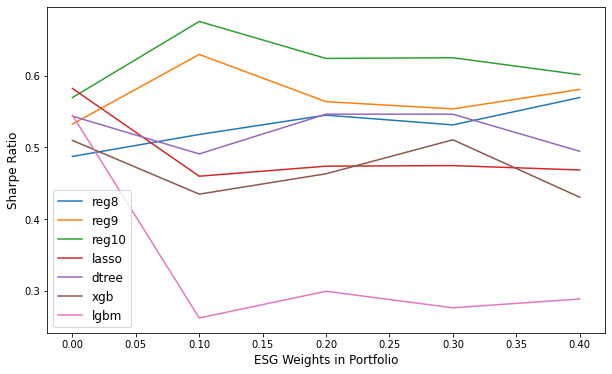

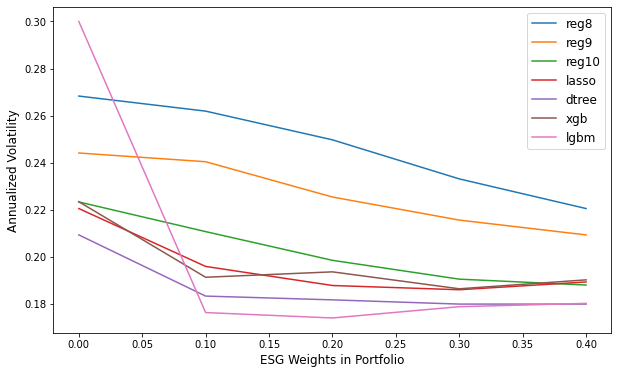

In [441]:
import matplotlib.pyplot as plt

temp = portfolio_dict[portfolio_dict['ESG Criteria'] == 'ALL']
models = temp['Model'].unique()

plt.figure(figsize=(10,6))
for model in models:
    temp_df = temp[temp['Model'] == model]
    plt.plot(temp_df['ESG Weights in Portfolio'], temp_df['Sharpe Ratio'], label = model)

plt.xlabel('ESG Weights in Portfolio', fontsize = 12)
plt.ylabel('Sharpe Ratio', fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('weight_sr.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(10,6))
for model in models:
    temp_df = temp[temp['Model'] == model]
    plt.plot(temp_df['ESG Weights in Portfolio'], temp_df['Annualized Volatility'], label = model)

plt.xlabel('ESG Weights in Portfolio', fontsize = 12)
plt.ylabel('Annualized Volatility', fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('weight_vol.png', dpi=300, bbox_inches='tight')
plt.show()


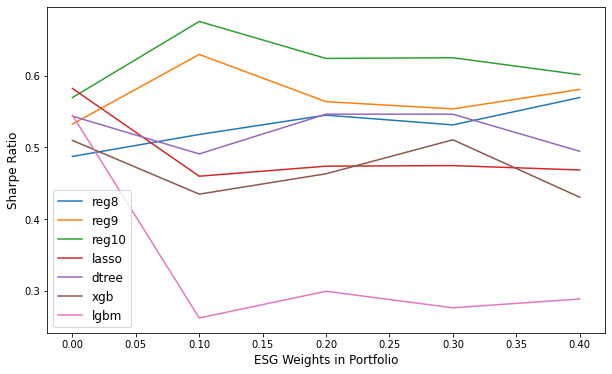

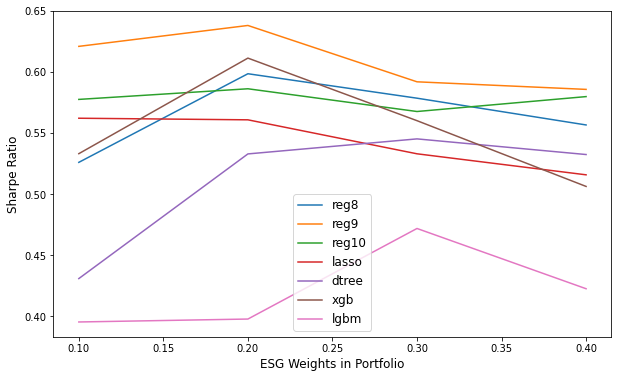

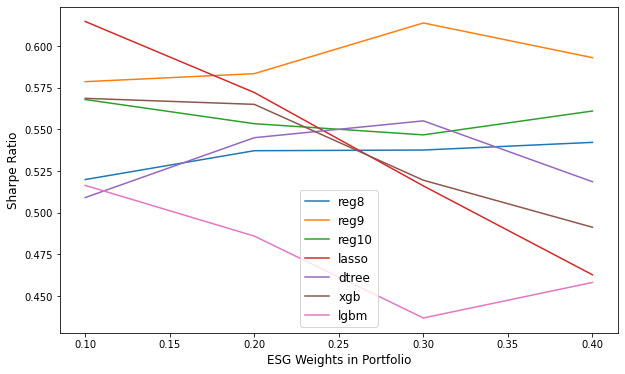

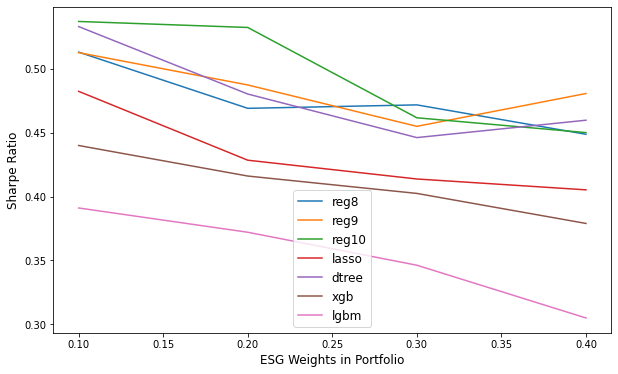

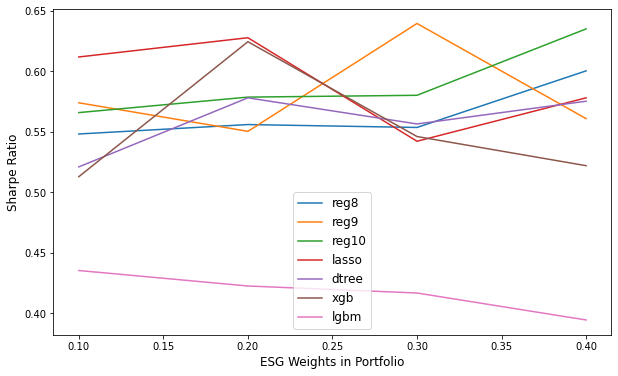

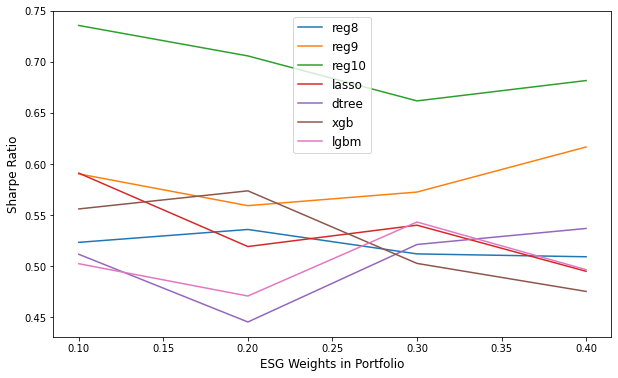

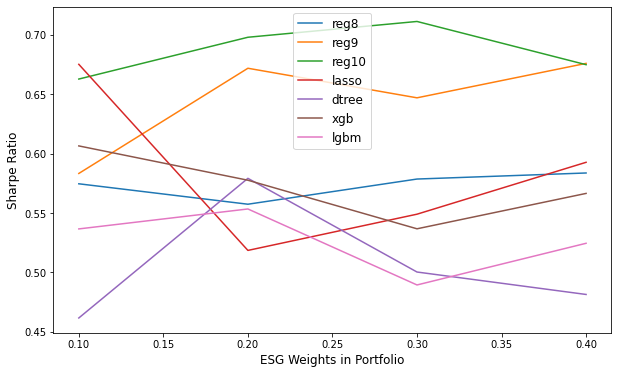

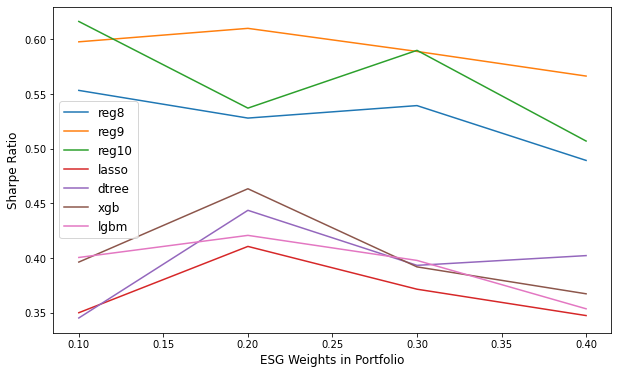

In [443]:
categories = ['ALL', 'ENV', 'COM', 'HUM', 'EMP', 'DIV', 'PRO', 'CGOV']
for category in categories:
    temp = portfolio_dict[portfolio_dict['ESG Criteria'] == category]
    models = temp['Model'].unique()

    plt.figure(figsize=(10,6))
    for model in models:
        temp_df = temp[temp['Model'] == model]
        plt.plot(temp_df['ESG Weights in Portfolio'], temp_df['Sharpe Ratio'], label = model)

    plt.xlabel('ESG Weights in Portfolio', fontsize = 12)
    plt.ylabel('Sharpe Ratio', fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()

In [444]:
# Find the top 10 rows with the highest annualized return
top_10_return = pd.DataFrame(portfolio_dict.nlargest(10, 'Annualized Returns'))
print("\nTop 10 rows with the highest annualized return:")
top_10_return


Top 10 rows with the highest annualized return:


,Model,ESG Criteria,ESG Weights in Portfolio,Annualized Returns,Annualized Volatility,Sharpe Ratio,CAPM beta,CAPM Treynor Ratio,Annualized Excess Returns,Tracking Error,Information Ratio
198,lgbm,ALL,0.0,0.1879,0.3000,0.5450,1.4442,0.1132,0.1166,0.2073,0.5624
59,reg9,PRO,0.2,0.1857,0.2402,0.6719,1.1917,0.1354,0.1089,0.1488,0.7316
28,reg8,PRO,0.4,0.1786,0.2645,0.5837,1.2922,0.1195,0.1045,0.1716,0.6091
25,reg8,PRO,0.1,0.1777,0.2673,0.5746,1.2636,0.1216,0.1032,0.1797,0.5746
87,reg10,DIV,0.1,0.1772,0.2081,0.7357,1.0326,0.1483,0.0965,0.1263,0.7643
38,reg9,ENV,0.1,0.1766,0.2454,0.6210,1.1259,0.1354,0.0982,0.1675,0.5862
61,reg9,PRO,0.4,0.1758,0.2244,0.6760,1.1236,0.1350,0.0974,0.1355,0.7188
34,reg9,ALL,0.1,0.1755,0.2404,0.6298,1.1435,0.1324,0.0979,0.1568,0.6246
6,reg8,ENV,0.2,0.1740,0.2504,0.5986,1.1766,0.1274,0.0973,0.1675,0.5809
60,reg9,PRO,0.3,0.1730,0.2303,0.6470,1.1654,0.1278,0.0963,0.1377,0.6993


In [445]:
# Find the top 10 rows with the highest Sharpe ratios
top_10_sharpe_ratios = pd.DataFrame(portfolio_dict.nlargest(10, 'Sharpe Ratio'))
print("\nTop 10 rows with the highest Sharpe ratios:")
top_10_sharpe_ratios


Top 10 rows with the highest Sharpe ratios:


,Model,ESG Criteria,ESG Weights in Portfolio,Annualized Returns,Annualized Volatility,Sharpe Ratio,CAPM beta,CAPM Treynor Ratio,Annualized Excess Returns,Tracking Error,Information Ratio
87,reg10,DIV,0.1,0.1772,0.2081,0.7357,1.0326,0.1483,0.0965,0.1263,0.7643
93,reg10,PRO,0.3,0.1723,0.2085,0.7113,1.1124,0.1333,0.0942,0.1111,0.8476
88,reg10,DIV,0.2,0.1650,0.1999,0.7059,0.9893,0.1427,0.0839,0.1218,0.6884
92,reg10,PRO,0.2,0.1726,0.2129,0.6980,1.1053,0.1344,0.0943,0.1201,0.7855
90,reg10,DIV,0.4,0.1513,0.1873,0.6818,0.9787,0.1304,0.0708,0.1028,0.6890
61,reg9,PRO,0.4,0.1758,0.2244,0.6760,1.1236,0.1350,0.0974,0.1355,0.7188
67,reg10,ALL,0.1,0.1662,0.2107,0.6758,1.0509,0.1355,0.0869,0.1264,0.6871
124,lasso,PRO,0.1,0.1611,0.2035,0.6752,1.0880,0.1263,0.0830,0.1079,0.7691
94,reg10,PRO,0.4,0.1640,0.2076,0.6749,1.1347,0.1235,0.0870,0.1042,0.8346
59,reg9,PRO,0.2,0.1857,0.2402,0.6719,1.1917,0.1354,0.1089,0.1488,0.7316


In [446]:
# Find the top 10 rows with the highest Information Ratios
top_10_info_ratios = pd.DataFrame(portfolio_dict.nlargest(10, 'Information Ratio'))
print("\nTop 10 rows with the highest Information ratios:")
top_10_info_ratios


Top 10 rows with the highest Information ratios:


,Model,ESG Criteria,ESG Weights in Portfolio,Annualized Returns,Annualized Volatility,Sharpe Ratio,CAPM beta,CAPM Treynor Ratio,Annualized Excess Returns,Tracking Error,Information Ratio
93,reg10,PRO,0.3,0.1723,0.2085,0.7113,1.1124,0.1333,0.0942,0.1111,0.8476
94,reg10,PRO,0.4,0.1640,0.2076,0.6749,1.1347,0.1235,0.0870,0.1042,0.8346
92,reg10,PRO,0.2,0.1726,0.2129,0.6980,1.1053,0.1344,0.0943,0.1201,0.7855
124,lasso,PRO,0.1,0.1611,0.2035,0.6752,1.0880,0.1263,0.0830,0.1079,0.7691
87,reg10,DIV,0.1,0.1772,0.2081,0.7357,1.0326,0.1483,0.0965,0.1263,0.7643
59,reg9,PRO,0.2,0.1857,0.2402,0.6719,1.1917,0.1354,0.1089,0.1488,0.7316
61,reg9,PRO,0.4,0.1758,0.2244,0.6760,1.1236,0.1350,0.0974,0.1355,0.7188
60,reg9,PRO,0.3,0.1730,0.2303,0.6470,1.1654,0.1278,0.0963,0.1377,0.6993
90,reg10,DIV,0.4,0.1513,0.1873,0.6818,0.9787,0.1304,0.0708,0.1028,0.6890
91,reg10,PRO,0.1,0.1710,0.2218,0.6628,1.1048,0.1331,0.0929,0.1348,0.6890


In [447]:
# Extract the highest Sharpe Ratio portfolio from each model
each_model_best = pd.DataFrame(portfolio_dict.groupby('Model').apply(lambda x: x.nlargest(1, 'Sharpe Ratio')))
each_model_best = each_model_best.sort_values(by = ['Sharpe Ratio'], ascending = False)
each_model_best = each_model_best.reset_index(drop=True)
each_model_best
# each_model_best.to_csv('hah.csv')


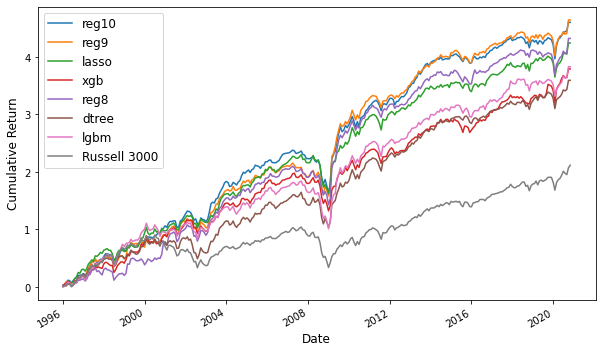

In [448]:
# Plot the cumulative return of the best portfolio of each model 
month_ret_dict = pd.DataFrame()
for row in each_model_best.iloc[:, :3].itertuples(index=False):
    month_ret = pd.read_excel(f"results/{row[0]}_{row[1]}_{row[2]}_MonthRet.xlsx", index_col=0)
    month_ret.rename(columns = {'Monthly_Returns': row[0]}, inplace = True)
    month_ret_dict = pd.merge(month_ret_dict, month_ret, how='outer', left_index=True, right_index=True)

# add benchmark to compare together
month_ret_dict = month_ret_dict.merge(
    rus3000[['rus_return']], on=['date'], how='left')
month_ret_dict.rename(columns = {'rus_return': 'Russell 3000'}, inplace = True)
month_ret_dict
    
month_ret_dict.cumsum().plot(figsize=(10, 6))
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Cumulative Return', fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('cum_sum.png', dpi=300, bbox_inches='tight')
plt.show()
